In [2]:
import pickle
from pathlib import Path
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import cv2
import numpy as np
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [3]:
import numpy as np

def find_thresholds(data):
    # 將數據轉換成numpy array，確保正確處理數據類型
    data_array = np.array(data)
    
    # 計算從10%到100%的分位數，每隔10%
    thresholds = np.percentile(data_array, np.arange(10, 101, 10))
    
    return thresholds.tolist()



In [4]:
df_all = pd.read_csv('./csv_data/mimic_all.csv')
df_nofinding = pd.read_csv('./csv_data_new/No_Finding.csv')
df_diagnose = pd.read_csv('./csv_data_new/Pneumothorax.csv')
df_diagnose['StudyID'] = df_diagnose['study_id']
df_nofinding['StudyID'] = df_nofinding['study_id']

In [5]:
print(df_all.columns)
print(df_diagnose.columns)

Index(['subject_id', 'dicom', 'StudyID', 'path', 'Exposure', 'ExposureInuAs',
       'XRayTubeCurrent', 'ExposureTime', 'race', 'gender'],
      dtype='object')
Index(['subject_id', 'study_id', 'StudyID'], dtype='object')


In [6]:
df_in_diagnose =df_all[df_all['StudyID'].isin(df_diagnose['StudyID'])]
df_in_no_finding =df_all[df_all['StudyID'].isin(df_nofinding['StudyID'])]

In [7]:
print("All Domain")
print(len(df_all))
print("Before")
print(len(df_diagnose), len(df_nofinding))
print("After")
print(len(df_in_diagnose), len(df_in_no_finding))

df_in_no_finding = df_in_no_finding.sample(len(df_in_diagnose))
#df_in_no_finding = df_in_no_finding.tail(len(df_in_diagnose))
print("After sample")
print(len(df_in_diagnose), len(df_in_no_finding))

All Domain
99642
Before
9332 78777
After
5706 20155
After sample
5706 5706


In [8]:
a = df_in_diagnose
b = df_in_no_finding
print(len(a), len(b))
#thresholds = np.unique(find_thresholds(data[feature]))

5706 5706


In [38]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score

def recursive_split(data, feature_names, indices_a, indices_b, path=[], depth=0, max_depth=3, total_a=None, total_b=None):
    if depth == 0:  # 在递归的最开始，确定a和b的总数
        total_a = indices_a.sum()
        total_b = indices_b.sum()

    if depth == max_depth or len(data) < 2:
        return None  # 停止递归的条件

    best_score = -1
    best_splits = None
    best_subgroups = None
    best_path = None
    ar = None
    br = None

    data = data.copy()  # 确保操作的是数据副本

    for feature in feature_names:
        thresholds = np.unique(find_thresholds(data[feature]))
        for threshold in thresholds:
            left_indices = data[feature] <= threshold
            right_indices = data[feature] > threshold
            
            left_group = data[left_indices].copy()
            right_group = data[right_indices].copy()

            # 更新cluster列
            data['cluster'] = 0
            data.loc[right_indices, 'cluster'] = 1

            # 确保有超过一个群体存在
            if len(np.unique(data['cluster'])) < 2:
                continue

            # 计算群内相似度分数
            cluster_labels = data['cluster']

            # 递归分割左右子群
            current_path = path + [(feature, threshold)]
            left_splits = recursive_split(left_group, feature_names, indices_a[left_indices], indices_b[left_indices], current_path, depth+1, max_depth, total_a, total_b)
            right_splits = recursive_split(right_group, feature_names, indices_a[right_indices], indices_b[right_indices], current_path, depth+1, max_depth, total_a, total_b)
            a_ratio = ((indices_a & (data['cluster'] == 0)).sum()) / total_a if total_a > 0 else 0
            b_ratio = ((indices_b & (data['cluster'] == 0)).sum()) / total_b if total_b > 0 else 0
            current_score = abs(a_ratio-b_ratio)
            if current_score > best_score:
            #if current_score > best_score and min(a_ratio,b_ratio)<0.45 and max(a_ratio,b_ratio)>0.5:
                best_score = current_score
                best_splits = (feature, threshold, current_score, depth)
                best_subgroups = (left_splits, right_splits)
                best_path = current_path
                ar = a_ratio
                br = b_ratio
    
                path_description = " > ".join([f"{p[0]} at {p[1]}" for p in best_path])
                print(f"A Ratio: {a_ratio:.2f}, B Ratio: {b_ratio:.2f}  Depth {depth}: Path '{path_description}', Score: {current_score:.2f} , Best Score: {best_score:.2f}")
                
            
            left_indices = data[feature] > threshold
            right_indices = data[feature] <= threshold
            
            left_group = data[left_indices].copy()
            right_group = data[right_indices].copy()

            # 更新cluster列
            data['cluster'] = 0
            data.loc[right_indices, 'cluster'] = 1

            # 确保有超过一个群体存在
            if len(np.unique(data['cluster'])) < 2:
                continue

            # 计算群内相似度分数
            cluster_labels = data['cluster']

            # 递归分割左右子群
            current_path = path + [(feature, threshold)]
            left_splits = recursive_split(left_group, feature_names, indices_a[left_indices], indices_b[left_indices], current_path, depth+1, max_depth, total_a, total_b)
            right_splits = recursive_split(right_group, feature_names, indices_a[right_indices], indices_b[right_indices], current_path, depth+1, max_depth, total_a, total_b)
            a_ratio = ((indices_a & (data['cluster'] == 0)).sum()) / total_a if total_a > 0 else 0
            b_ratio = ((indices_b & (data['cluster'] == 0)).sum()) / total_b if total_b > 0 else 0
            current_score = abs(a_ratio-b_ratio)
            if current_score > best_score:
            #if current_score > best_score and min(a_ratio,b_ratio)<0.45 and max(a_ratio,b_ratio)>0.5:
                best_score = current_score
                best_splits = (feature, threshold, current_score, depth)
                best_subgroups = (left_splits, right_splits)
                best_path = current_path
                ar = a_ratio
                br = b_ratio
    
                path_description = " > ".join([f"{p[0]} at {p[1]}" for p in best_path])
                print(f"RR A Ratio: {a_ratio:.2f}, B Ratio: {b_ratio:.2f}  Depth {depth}: Path '{path_description}', Score: {current_score:.2f} , Best Score: {best_score:.2f}")

    return best_splits, best_subgroups, best_path, best_score, ar, br

# 准备数据和执行递归分割
combined = pd.concat([a, b], ignore_index=True)
features = ['Exposure', 'ExposureInuAs', 'XRayTubeCurrent', 'ExposureTime']

indices_a = pd.Series([True] * len(a) + [False] * len(b))
indices_b = pd.Series([False] * len(a) + [True] * len(b))

max_tree_depth = 3 # 最大深度设为3层
best_splits, best_subgroups, best_path, best_score, ar, br = recursive_split(combined, features, indices_a, indices_b, max_depth=max_tree_depth)


A Ratio: 0.74, B Ratio: 0.44  Depth 2: Path 'Exposure at 3.0 > ExposureInuAs at 3200.0 > XRayTubeCurrent at 320.0', Score: 0.30 , Best Score: 0.30
A Ratio: 0.00, B Ratio: 0.00  Depth 2: Path 'Exposure at 3.0 > ExposureInuAs at 3200.0 > ExposureInuAs at 3217.8', Score: 0.00 , Best Score: 0.00
A Ratio: 0.74, B Ratio: 0.48  Depth 1: Path 'Exposure at 3.0 > ExposureInuAs at 3200.0', Score: 0.26 , Best Score: 0.26
A Ratio: 0.00, B Ratio: 0.00  Depth 2: Path 'Exposure at 3.0 > ExposureInuAs at 3200.0 > ExposureInuAs at 3217.8', Score: 0.00 , Best Score: 0.00
A Ratio: 0.74, B Ratio: 0.44  Depth 2: Path 'Exposure at 3.0 > ExposureInuAs at 3200.0 > XRayTubeCurrent at 320.0', Score: 0.30 , Best Score: 0.30
A Ratio: 0.74, B Ratio: 0.44  Depth 2: Path 'Exposure at 3.0 > XRayTubeCurrent at 320.0 > ExposureInuAs at 3200.0', Score: 0.30 , Best Score: 0.30
A Ratio: 0.74, B Ratio: 0.44  Depth 2: Path 'Exposure at 3.0 > XRayTubeCurrent at 320.0 > ExposureTime at 10.0', Score: 0.30 , Best Score: 0.30
A R

In [39]:
print(best_path, best_score, ar, br)

[('XRayTubeCurrent', 320.0)] 0.34349807220469686 0.984577637574483 0.6410795653697862


# Group verify

In [11]:
print(len(df_in_diagnose), len(df_in_no_finding))

5706 5706


In [12]:
df_in_diagnose['diagnose_label'] = 1
df_in_no_finding['diagnose_label'] = 0

/var/folders/z4/mbl70bkn0sjgq2yfg5rc6xp40000gn/T/ipykernel_13513/3388423798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_diagnose['diagnose_label'] = 1


In [ ]:
'ExposureTime at 12.0 > XRayTubeCurrent at 400.0 > XRayTubeCurrent at 320.0'

ExposureTime 12 Exposure 3 XRayTubeCurrent 320

In [42]:
root_name= 'XRayTubeCurrent'
root_val = 320

r_name = 'XRayTubeCurrent'
r_val = -400000 #small

l_name = 'XRayTubeCurrent'
l_val = 3200000 #big



df_in_diagnose['parameter_label'] = np.where(
    df_in_diagnose[root_name] <= root_val,  
    np.where(df_in_diagnose[l_name] <= l_val, 1, 0),  
    np.where(df_in_diagnose[r_name] <= r_val, 1, 0)  
)

df_in_no_finding['parameter_label'] = np.where(
    df_in_no_finding[root_name] <= root_val,  
    np.where(df_in_no_finding[l_name] <= l_val, 1, 0),  
    np.where(df_in_no_finding[r_name] <= r_val, 1, 0)  
)

/var/folders/z4/mbl70bkn0sjgq2yfg5rc6xp40000gn/T/ipykernel_13513/1682090334.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_diagnose['parameter_label'] = np.where(


In [47]:
print(df_in_diagnose['parameter_label'].sum()/len(df_in_diagnose))
print(df_in_no_finding['parameter_label'].sum()/len(df_in_no_finding))

print(len(df_in_no_finding))



0.984577637574483
0.6410795653697862
5706


/var/folders/z4/mbl70bkn0sjgq2yfg5rc6xp40000gn/T/ipykernel_13513/4016731971.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['parameter_label'] == 1, 'parameter_label'] = 'A'
/var/folders/z4/mbl70bkn0sjgq2yfg5rc6xp40000gn/T/ipykernel_13513/4016731971.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Postive' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['diagnose_label'] == 1, 'diagnose_label'] = 'Postive'


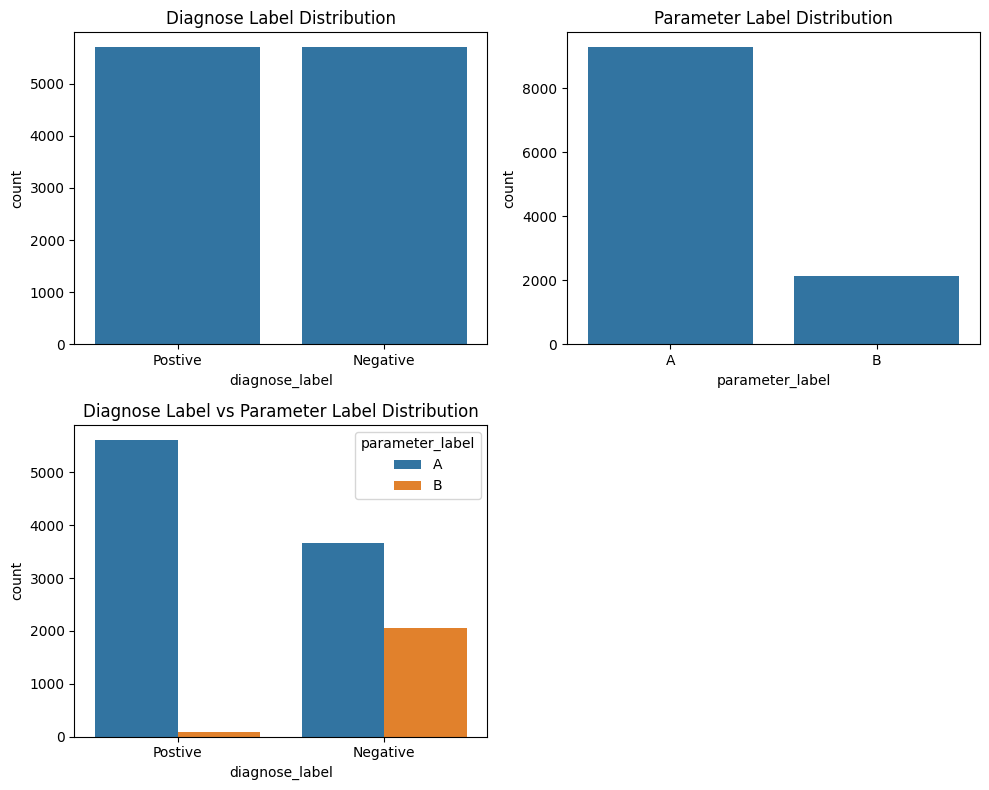

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 創建一個示例DataFrame，這裡需要根據你的實際資料來載入或創建DataFrame
data = pd.concat([df_in_diagnose, df_in_no_finding], axis=0)
data.loc[data['parameter_label'] == 1, 'parameter_label'] = 'A'
data.loc[data['parameter_label'] != 'A', 'parameter_label'] = 'B'
data.loc[data['diagnose_label'] == 1, 'diagnose_label'] = 'Postive'
data.loc[data['diagnose_label'] != 'Postive', 'diagnose_label'] = 'Negative'

# 創建一個四宮格的子圖
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# 將diagnose_label的分佈繪製在左上角子圖中
sns.countplot(data=data, x='diagnose_label', ax=axs[0, 0])
axs[0, 0].set_title('Diagnose Label Distribution')

# 將parameter_label的分佈繪製在右上角子圖中
sns.countplot(data=data, x='parameter_label', ax=axs[0, 1])
axs[0, 1].set_title('Parameter Label Distribution')

# 將diagnose_label和parameter_label的組合分佈繪製在左下角子圖中
sns.countplot(data=data, x='diagnose_label', hue='parameter_label', ax=axs[1, 0])
axs[1, 0].set_title('Diagnose Label vs Parameter Label Distribution')

# 移除右下角子圖
fig.delaxes(axs[1,1])

plt.tight_layout()
plt.show()


In [27]:
def find_best_combination(df_in_diagnose, df_in_no_finding):
    features = ['Exposure', 'ExposureInuAs', 'XRayTubeCurrent', 'ExposureTime']
    combined = pd.concat([df_in_diagnose, df_in_no_finding], ignore_index=True)
    for feature0 in features:
        print(type(feature0))
        thresholds0_all = np.unique(find_thresholds(combined[feature0]))
        for thresholds0 in thresholds0_all:
            for feature1 in features:
                thresholds1_all = np.unique(find_thresholds(combined[feature1]))
                for thresholds1 in thresholds1_all:
                    for feature2 in features:
                        thresholds2_all = np.unique(find_thresholds(combined[feature2]))
                        for thresholds2 in thresholds2_all:
                            root_name= feature0
                            root_val = thresholds0

                            r_name = feature1
                            r_val = thresholds1

                            l_name = feature2
                            l_val = thresholds2

                            df_in_diagnose['parameter label'] = np.where(
                                df_in_diagnose[root_name] <= root_val,  
                                np.where(df_in_diagnose[l_name] <= l_val, 1, 0),  
                                np.where(df_in_diagnose[r_name] <= r_val, 1, 0)  
                            )

                            df_in_no_finding['parameter label'] = np.where(
                                df_in_no_finding[root_name] <= root_val,  
                                np.where(df_in_no_finding[l_name] <= l_val, 1, 0),  
                                np.where(df_in_no_finding[r_name] <= r_val, 1, 0)  
                            )
                            path_now = [(feature0,thresholds0),(feature1,thresholds1),(feature2,thresholds2)]
                            df_in_diagnose_ratio = df_in_diagnose['parameter label'].sum()/len(df_in_diagnose)
                            df_in_no_finding_ratio = df_in_no_finding['parameter label'].sum()/len(df_in_no_finding)
                            if(abs(df_in_diagnose_ratio-df_in_no_finding_ratio)>0.25 and min(df_in_diagnose_ratio,df_in_no_finding_ratio)<0.5):
                                print(f"diagnose_ratio: {df_in_diagnose_ratio:.3f}, no_finding_ratio: {df_in_no_finding_ratio:.3f} : Path '{path_now}', Score: {abs(df_in_diagnose_ratio-df_in_no_finding_ratio):.3f}")

In [28]:
find_best_combination(df_in_diagnose,df_in_no_finding)

<class 'str'>
diagnose_ratio: 0.745, no_finding_ratio: 0.481 : Path '[('Exposure', 3.0), ('Exposure', 3.0), ('Exposure', 3.0)]', Score: 0.264
diagnose_ratio: 0.745, no_finding_ratio: 0.481 : Path '[('Exposure', 3.0), ('Exposure', 3.0), ('Exposure', 4.0)]', Score: 0.264
diagnose_ratio: 0.745, no_finding_ratio: 0.481 : Path '[('Exposure', 3.0), ('Exposure', 3.0), ('Exposure', 5.0)]', Score: 0.264
diagnose_ratio: 0.745, no_finding_ratio: 0.481 : Path '[('Exposure', 3.0), ('Exposure', 3.0), ('Exposure', 63.0)]', Score: 0.264
diagnose_ratio: 0.745, no_finding_ratio: 0.481 : Path '[('Exposure', 3.0), ('Exposure', 3.0), ('ExposureInuAs', 3200.0)]', Score: 0.264
diagnose_ratio: 0.745, no_finding_ratio: 0.481 : Path '[('Exposure', 3.0), ('Exposure', 3.0), ('ExposureInuAs', 4000.0)]', Score: 0.264
diagnose_ratio: 0.745, no_finding_ratio: 0.481 : Path '[('Exposure', 3.0), ('Exposure', 3.0), ('ExposureInuAs', 5000.0)]', Score: 0.264
diagnose_ratio: 0.745, no_finding_ratio: 0.481 : Path '[('Exposur

/var/folders/z4/mbl70bkn0sjgq2yfg5rc6xp40000gn/T/ipykernel_13513/931254527.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_diagnose['parameter label'] = np.where(


diagnose_ratio: 0.745, no_finding_ratio: 0.481 : Path '[('Exposure', 5.0), ('ExposureInuAs', 5000.0), ('Exposure', 3.0)]', Score: 0.264
diagnose_ratio: 0.745, no_finding_ratio: 0.481 : Path '[('Exposure', 5.0), ('ExposureInuAs', 5000.0), ('ExposureInuAs', 3200.0)]', Score: 0.264
diagnose_ratio: 0.745, no_finding_ratio: 0.481 : Path '[('Exposure', 5.0), ('ExposureTime', 5.0), ('Exposure', 3.0)]', Score: 0.264
diagnose_ratio: 0.745, no_finding_ratio: 0.481 : Path '[('Exposure', 5.0), ('ExposureTime', 5.0), ('ExposureInuAs', 3200.0)]', Score: 0.264
diagnose_ratio: 0.745, no_finding_ratio: 0.481 : Path '[('Exposure', 63.0), ('Exposure', 3.0), ('Exposure', 3.0)]', Score: 0.264
diagnose_ratio: 0.745, no_finding_ratio: 0.481 : Path '[('Exposure', 63.0), ('Exposure', 3.0), ('ExposureInuAs', 3200.0)]', Score: 0.264
diagnose_ratio: 0.745, no_finding_ratio: 0.481 : Path '[('Exposure', 63.0), ('Exposure', 4.0), ('Exposure', 3.0)]', Score: 0.264
diagnose_ratio: 0.745, no_finding_ratio: 0.481 : Path